## 이미지 처리 딥러닝
# 전이학습

### 유명한 CNN 아키텍처
- https://m.blog.naver.com/takion7/221633332572
> - LeNet
> - AlexNet
> - Inception (GoogleNet)
> - VGGNet (VGG16)
> - ResNet
> - Xception (Inception 기반)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

ImportError: Traceback (most recent call last):
  File "C:\Users\kwjeon31\.conda\envs\py39tf2GPU\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: 이 작업을 완료하기 위한 페이징 파일이 너무 작습니다.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
dir(keras.applications)

### VGG16 분류

In [3]:
model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')
    # input_shape=(224, 224, 3)

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

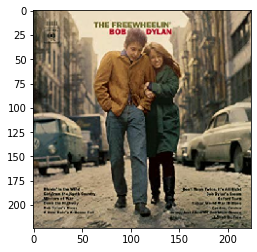

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

bob = load_img('bob_dylan.jpg', target_size=(224, 224))
bob = img_to_array(bob)
plt.imshow(bob/255.)

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

input_image = np.expand_dims(bob, axis=0) # (1,224,224,3)
input_image = preprocess_input(input_image)

input_image.shape, input_image.max(), input_image.min()

((1, 224, 224, 3), 138.22101, -123.68)

In [7]:
result = model.predict(input_image)
result.shape

(1, 1000)

In [11]:
np.argsort(result[0])[::-1][:10]

array([675, 468, 734, 654, 569, 656, 407, 708, 561, 879], dtype=int64)

In [9]:
from tensorflow.keras.applications.vgg16 import decode_predictions

decode_predictions(result, top=10)

[[('n03796401', 'moving_van', 0.19497377),
  ('n02930766', 'cab', 0.090121895),
  ('n03977966', 'police_van', 0.06556545),
  ('n03769881', 'minibus', 0.051681608),
  ('n03417042', 'garbage_truck', 0.048492372),
  ('n03770679', 'minivan', 0.030116377),
  ('n02701002', 'ambulance', 0.026512029),
  ('n03903868', 'pedestal', 0.017055947),
  ('n03384352', 'forklift', 0.015942968),
  ('n04507155', 'umbrella', 0.015372179)]]

- 중간층 출력이미지 확인

In [13]:
for i,layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten
20 fc1
21 fc2
22 predictions


In [14]:
#block3_conv1 = vgg16.get_layer('block3_conv1')
activation_model = keras.models.Model(inputs=model.input,
                        outputs=model.layers[7].output) # block3_conv1

In [15]:
result = activation_model.predict(input_image)
result.shape

(1, 56, 56, 256)

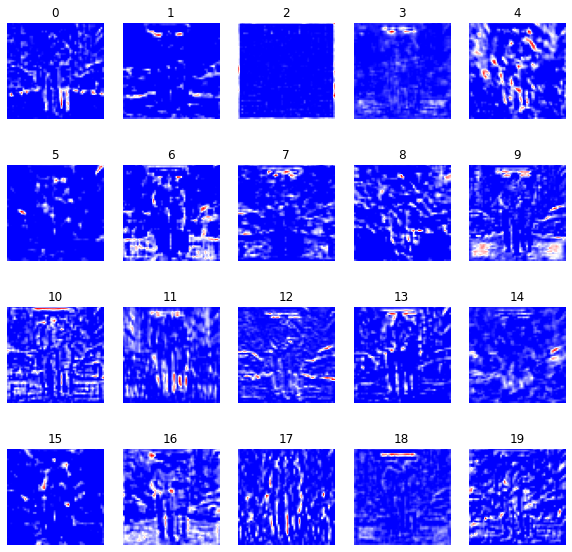

In [18]:
plt.figure(figsize=[10,10])

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(result[0,:,:,i], cmap='bwr')
    plt.axis('off')
    plt.title(i)

### VGG16 전이학습

In [23]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',
                            input_shape=(150,150,3))

In [24]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
datagen = ImageDataGenerator(rescale=1/255)

generator = datagen.flow_from_directory('cats_and_dogs_small/train',
                    target_size=(150,150), batch_size=20, class_mode='binary')

X_train = np.zeros([2000,4,4,512])
y_train = np.zeros(2000)

for step in range(100): # 2000//20
    X_batch, y_batch = generator.next()
    pred = vgg16.predict(X_batch)
    
    X_train[20*step:20*(step+1)] = pred
    y_train[20*step:20*(step+1)] = y_batch
    print('.', end='')
    
X_train.shape, y_train.shape

Found 2000 images belonging to 2 classes.
....................................................................................................

((2000, 4, 4, 512), (2000,))

In [39]:
np.savez('cats_and_dogs_vgg.npz', x=X_train, y=y_train)

In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(4,4,512)))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
history = model.fit(X_train, y_train, epochs=10, batch_size=20,
                   validation_split=0.2)

Epoch 1/10
80/80 [==============================] - 9s 80ms/step - loss: 0.7374 - acc: 0.6854 - val_loss: 0.2698 - val_acc: 0.8950
Epoch 2/10
80/80 [==============================] - 6s 70ms/step - loss: 0.2431 - acc: 0.8926 - val_loss: 0.2606 - val_acc: 0.8775
Epoch 3/10
80/80 [==============================] - 6s 78ms/step - loss: 0.2303 - acc: 0.9103 - val_loss: 0.2302 - val_acc: 0.9150
Epoch 4/10
80/80 [==============================] - 6s 72ms/step - loss: 0.1711 - acc: 0.9305 - val_loss: 0.3012 - val_acc: 0.8625
Epoch 5/10
80/80 [==============================] - 6s 71ms/step - loss: 0.1559 - acc: 0.9446 - val_loss: 0.2109 - val_acc: 0.8975
Epoch 6/10
80/80 [==============================] - 6s 70ms/step - loss: 0.1172 - acc: 0.9577 - val_loss: 0.2558 - val_acc: 0.9150
Epoch 7/10
80/80 [==============================] - 6s 72ms/step - loss: 0.0868 - acc: 0.9660 - val_loss: 0.2229 - val_acc: 0.9125
Epoch 8/10
80/80 [==============================] - 6s 71ms/step - loss: 0.0700 - a

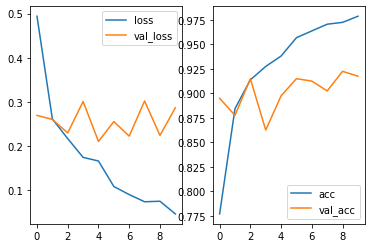

In [44]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

### Inception

In [45]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions

In [46]:
base_model = InceptionV3(weights='imagenet', include_top=True)

In [47]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_32 (Activation)      (None, 17, 17, 128)  0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 17, 17, 128)  0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 17, 17, 192)  172032      activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_38 

conv2d_68 (Conv2D)              (None, 17, 17, 192)  258048      activation_67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 17, 17, 192)  147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 17, 17, 192)  576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 17, 17, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 17, 17, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_norm

Total params: 23,851,784
Trainable params: 23,817,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [48]:
for i,layer in enumerate(base_model.layers):
    print(i, layer.name, layer.output_shape)

0 input_3 [(None, 299, 299, 3)]
1 conv2d (None, 149, 149, 32)
2 batch_normalization (None, 149, 149, 32)
3 activation (None, 149, 149, 32)
4 conv2d_1 (None, 147, 147, 32)
5 batch_normalization_1 (None, 147, 147, 32)
6 activation_1 (None, 147, 147, 32)
7 conv2d_2 (None, 147, 147, 64)
8 batch_normalization_2 (None, 147, 147, 64)
9 activation_2 (None, 147, 147, 64)
10 max_pooling2d (None, 73, 73, 64)
11 conv2d_3 (None, 73, 73, 80)
12 batch_normalization_3 (None, 73, 73, 80)
13 activation_3 (None, 73, 73, 80)
14 conv2d_4 (None, 71, 71, 192)
15 batch_normalization_4 (None, 71, 71, 192)
16 activation_4 (None, 71, 71, 192)
17 max_pooling2d_1 (None, 35, 35, 192)
18 conv2d_8 (None, 35, 35, 64)
19 batch_normalization_8 (None, 35, 35, 64)
20 activation_8 (None, 35, 35, 64)
21 conv2d_6 (None, 35, 35, 48)
22 conv2d_9 (None, 35, 35, 96)
23 batch_normalization_6 (None, 35, 35, 48)
24 batch_normalization_9 (None, 35, 35, 96)
25 activation_6 (None, 35, 35, 48)
26 activation_9 (None, 35, 35, 96)
27 aver

In [50]:
base_model.get_layer('input_3').output_shape

[(None, 299, 299, 3)]

- Inception-v3 의 입력이미지는 299x299x3 이고,
- -1 ~ 1 사이의 실수값으로 전처리한다

In [52]:
img = keras.preprocessing.image.load_img('bob_dylan.jpg', target_size=(299,299))
bob = keras.preprocessing.image.img_to_array(img)
bob = ((bob/255.)-0.5)*2

In [53]:
bob.shape, bob.max(), bob.min(), bob.dtype

((299, 299, 3), 1.0, -1.0, dtype('float32'))

In [54]:
out = base_model.predict(bob.reshape(1,299,299,3))

In [55]:
out.argmax(axis=1)

array([608], dtype=int64)

In [56]:
decode_predictions(out, top=10)

[[('n03594734', 'jean', 0.104483455),
  ('n03404251', 'fur_coat', 0.09519394),
  ('n02667093', 'abaya', 0.055765286),
  ('n02992529', 'cellular_telephone', 0.045668956),
  ('n04350905', 'suit', 0.027277812),
  ('n02971356', 'carton', 0.026119256),
  ('n02930766', 'cab', 0.022437474),
  ('n03110669', 'cornet', 0.01632045),
  ('n02672831', 'accordion', 0.015340676),
  ('n04356056', 'sunglasses', 0.015183685)]]

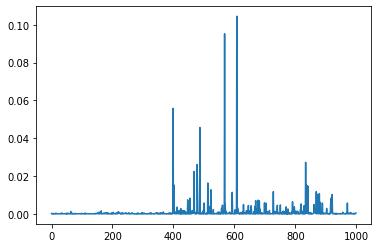

In [57]:
plt.plot(out.ravel())

In [58]:
base_model = InceptionV3(weights='imagenet', include_top=False,
                        input_shape=(299,299,3))

In [59]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

activation_125 (Activation)     (None, 17, 17, 128)  0           batch_normalization_125[0][0]    
__________________________________________________________________________________________________
activation_130 (Activation)     (None, 17, 17, 128)  0           batch_normalization_130[0][0]    
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 17, 17, 128)  114688      activation_125[0][0]             
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 17, 17, 128)  114688      activation_130[0][0]             
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 17, 17, 128)  384         conv2d_126[0][0]                 
__________________________________________________________________________________________________
batch_norm

conv2d_157 (Conv2D)             (None, 17, 17, 192)  258048      activation_156[0][0]             
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 17, 17, 192)  258048      activation_161[0][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 17, 17, 192)  147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 17, 17, 192)  576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 17, 17, 192)  576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_norm

Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [60]:
for i,layer in enumerate(base_model.layers):
    print(i, layer.name, layer.output_shape)

0 input_4 [(None, 299, 299, 3)]
1 conv2d_94 (None, 149, 149, 32)
2 batch_normalization_94 (None, 149, 149, 32)
3 activation_94 (None, 149, 149, 32)
4 conv2d_95 (None, 147, 147, 32)
5 batch_normalization_95 (None, 147, 147, 32)
6 activation_95 (None, 147, 147, 32)
7 conv2d_96 (None, 147, 147, 64)
8 batch_normalization_96 (None, 147, 147, 64)
9 activation_96 (None, 147, 147, 64)
10 max_pooling2d_4 (None, 73, 73, 64)
11 conv2d_97 (None, 73, 73, 80)
12 batch_normalization_97 (None, 73, 73, 80)
13 activation_97 (None, 73, 73, 80)
14 conv2d_98 (None, 71, 71, 192)
15 batch_normalization_98 (None, 71, 71, 192)
16 activation_98 (None, 71, 71, 192)
17 max_pooling2d_5 (None, 35, 35, 192)
18 conv2d_102 (None, 35, 35, 64)
19 batch_normalization_102 (None, 35, 35, 64)
20 activation_102 (None, 35, 35, 64)
21 conv2d_100 (None, 35, 35, 48)
22 conv2d_103 (None, 35, 35, 96)
23 batch_normalization_100 (None, 35, 35, 48)
24 batch_normalization_103 (None, 35, 35, 96)
25 activation_100 (None, 35, 35, 48)
26 

244 batch_normalization_169 (None, 8, 8, 192)
245 activation_165 (None, 8, 8, 320)
246 activation_169 (None, 8, 8, 192)
247 max_pooling2d_7 (None, 8, 8, 768)
248 mixed8 (None, 8, 8, 1280)
249 conv2d_174 (None, 8, 8, 448)
250 batch_normalization_174 (None, 8, 8, 448)
251 activation_174 (None, 8, 8, 448)
252 conv2d_171 (None, 8, 8, 384)
253 conv2d_175 (None, 8, 8, 384)
254 batch_normalization_171 (None, 8, 8, 384)
255 batch_normalization_175 (None, 8, 8, 384)
256 activation_171 (None, 8, 8, 384)
257 activation_175 (None, 8, 8, 384)
258 conv2d_172 (None, 8, 8, 384)
259 conv2d_173 (None, 8, 8, 384)
260 conv2d_176 (None, 8, 8, 384)
261 conv2d_177 (None, 8, 8, 384)
262 average_pooling2d_16 (None, 8, 8, 1280)
263 conv2d_170 (None, 8, 8, 320)
264 batch_normalization_172 (None, 8, 8, 384)
265 batch_normalization_173 (None, 8, 8, 384)
266 batch_normalization_176 (None, 8, 8, 384)
267 batch_normalization_177 (None, 8, 8, 384)
268 conv2d_178 (None, 8, 8, 192)
269 batch_normalization_170 (None, 8, 

In [63]:
base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

conv2d_124 (Conv2D)             (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 17, 17, 192)  172032      activation_126[0][0]             
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 17, 17, 192)  172032      activation_131[0][0]             
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 17, 17, 192)  147456      average_pooling2d_12[0][0]       
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 17, 17, 192)  576         conv2d_124[0][0]                 
__________________________________________________________________________________________________
batch_norm

batch_normalization_166 (BatchN (None, 17, 17, 192)  576         conv2d_166[0][0]                 
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 17, 17, 192)  0           batch_normalization_166[0][0]    
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 17, 17, 192)  258048      activation_166[0][0]             
__________________________________________________________________________________________________
batch_normalization_167 (BatchN (None, 17, 17, 192)  576         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 17, 17, 192)  0           batch_normalization_167[0][0]    
__________________________________________________________________________________________________
conv2d_164

In [65]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

In [66]:
train_datagen = ImageDataGenerator(rescale=1/255.)
# train_datagen = ImageDataGenerator(rescale=1/255.,
#    preprocessing_function=lambda x: (x-0.5)*2.)

train_generator = train_datagen.flow_from_directory(
    'cats_and_dogs_small/train',
    target_size=(299,299),
    batch_size=20,
    class_mode='binary') # categorical, sparse(정수레이블), binary, input(입력이미지)

Found 2000 images belonging to 2 classes.


In [67]:
validation_datagen = ImageDataGenerator(rescale=1/255.)

validation_generator = train_datagen.flow_from_directory(
    'cats_and_dogs_small/validation',
    target_size=(299,299),
    batch_size=20,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=100,
                validation_data=validation_generator, validation_steps=50)

```
Epoch 1/10
100/100 [==============================] - 3369s 34s/step - loss: 0.5637 - acc: 0.7610 - val_loss: 0.3421 - val_acc: 0.9700
Epoch 2/10
100/100 [==============================] - 3332s 33s/step - loss: 0.3107 - acc: 0.9741 - val_loss: 0.1992 - val_acc: 0.9870
Epoch 3/10
100/100 [==============================] - 3341s 34s/step - loss: 0.1838 - acc: 0.9828 - val_loss: 0.1286 - val_acc: 0.9880
Epoch 4/10
100/100 [==============================] - 3319s 33s/step - loss: 0.1180 - acc: 0.9913 - val_loss: 0.0935 - val_acc: 0.9900
Epoch 5/10
100/100 [==============================] - 3322s 33s/step - loss: 0.0944 - acc: 0.9885 - val_loss: 0.0738 - val_acc: 0.9910
Epoch 6/10
100/100 [==============================] - 3322s 33s/step - loss: 0.0775 - acc: 0.9897 - val_loss: 0.0617 - val_acc: 0.9920
Epoch 7/10
100/100 [==============================] - 3320s 33s/step - loss: 0.0587 - acc: 0.9919 - val_loss: 0.0536 - val_acc: 0.9930
Epoch 8/10
100/100 [==============================] - 3330s 33s/step - loss: 0.0533 - acc: 0.9903 - val_loss: 0.0479 - val_acc: 0.9930
Epoch 9/10
100/100 [==============================] - 3359s 34s/step - loss: 0.0469 - acc: 0.9915 - val_loss: 0.0438 - val_acc: 0.9940
Epoch 10/10
100/100 [==============================] - 3352s 34s/step - loss: 0.0403 - acc: 0.9930 - val_loss: 0.0404 - val_acc: 0.9940
```